In [1]:
import torch
import torch.nn as nn

import tensorflow as tf
from tensorflow.keras.datasets import mnist

### Dataset and Preprocessing

In [2]:
(X, y), (Xtest, ytest) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
X.shape, y.shape, Xtest.shape, ytest.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, 28*28))
Xtest = scaler.transform(Xtest.reshape(-1, 28*28))

In [6]:
X.shape, Xtest.shape

((60000, 784), (10000, 784))

In [7]:
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(42)

In [8]:
class customDataset(Dataset):
  def __init__(self, X, Y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.Y = torch.tensor(Y, dtype=torch.long)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, i):
    return self.X[i], self.Y[i]

In [9]:
train_dataset = customDataset(X, y)
test_dataset = customDataset(Xtest, ytest)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, pin_memory=True)

In [10]:
len(train_dataset), train_dataset[0][0].shape

(60000, torch.Size([784]))

In [11]:
learning_rate = 0.01
epoch = 100

## Move the model to GPU
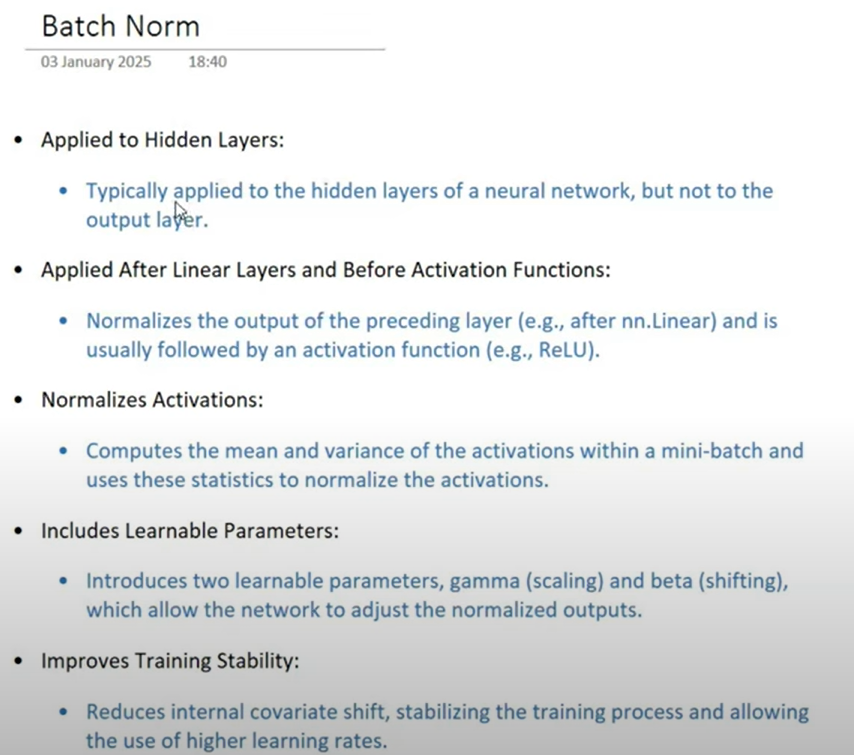


- Regularization effect
- Consistent during evaluation

In [23]:
class NN(nn.Module):
  def __init__(self, input_dim):
    super().__init__()
    self.network = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64, 10)
    )

  def forward(self, X):
    return self.network(X)

In [24]:
model = NN(X.shape[1])
model.to(device)

NN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [25]:
!pip install torchinfo

In [26]:
from torchinfo import summary

summary(model, input_size=(32, 784))

Layer (type:depth-idx)                   Output Shape              Param #
NN                                       [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Linear: 2-1                       [32, 128]                 100,480
│    └─BatchNorm1d: 2-2                  [32, 128]                 256
│    └─ReLU: 2-3                         [32, 128]                 --
│    └─Dropout: 2-4                      [32, 128]                 --
│    └─Linear: 2-5                       [32, 64]                  8,256
│    └─BatchNorm1d: 2-6                  [32, 64]                  128
│    └─ReLU: 2-7                         [32, 64]                  --
│    └─Dropout: 2-8                      [32, 64]                  --
│    └─Linear: 2-9                       [32, 10]                  650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.51
Input size (MB): 0.10
Forward/ba

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4) # adding lambda term "weight_decay" which will use L2 regularization


for i in range(epoch):
  total_epoch_loss = 0
  for batch_x, batch_y in train_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    y_pred = model(batch_x)
    loss = criterion(y_pred, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f'Epoch: {i + 1} | loss : {avg_loss}')

Epoch: 1 | loss : 1.1889532521081123
Epoch: 2 | loss : 0.5607605396049109
Epoch: 3 | loss : 0.42326626772565373
Epoch: 4 | loss : 0.3712398210314037
Epoch: 5 | loss : 0.334656655375383
Epoch: 6 | loss : 0.30930497000085266
Epoch: 7 | loss : 0.28807692128076734
Epoch: 8 | loss : 0.2742310032597991
Epoch: 9 | loss : 0.2561513413307763
Epoch: 10 | loss : 0.24757970305584642
Epoch: 11 | loss : 0.23446025559579386
Epoch: 12 | loss : 0.22389557511249839
Epoch: 13 | loss : 0.21352998378561505
Epoch: 14 | loss : 0.20644223518463087
Epoch: 15 | loss : 0.20040610750346805
Epoch: 16 | loss : 0.19686002235041497
Epoch: 17 | loss : 0.19215894754189672
Epoch: 18 | loss : 0.18575606778708856
Epoch: 19 | loss : 0.17830987401735554
Epoch: 20 | loss : 0.17469375982467553
Epoch: 21 | loss : 0.17037914517814162
Epoch: 22 | loss : 0.1634100854222073
Epoch: 23 | loss : 0.16138963434678405
Epoch: 24 | loss : 0.1614749722246295
Epoch: 25 | loss : 0.15454269853482114
Epoch: 26 | loss : 0.15343162928149898
Epoc

In [28]:
model.eval()

NN(
  (network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [29]:
total = 0
correct = 0

with torch.no_grad():
  for batch_x, batch_y in test_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    y_pred = model(batch_x)
    _, predicted = torch.max(y_pred.data, 1)
    total += batch_y.shape[0]
    correct += (predicted == batch_y).sum().item()

print(f'Accuracy: {100 * correct / total}')

Accuracy: 97.7


In [30]:
total = 0
correct = 0

with torch.no_grad():
  for batch_x, batch_y in train_loader:
    batch_x = batch_x.to(device)
    batch_y = batch_y.to(device)
    y_pred = model(batch_x)
    _, predicted = torch.max(y_pred.data, 1)
    total += batch_y.shape[0]
    correct += (predicted == batch_y).sum().item()

print(f'Accuracy: {100 * correct / total}')

Accuracy: 99.68833333333333
